# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

***DICCIONARIO DE DATOS*** 

Existe cinco tablas en el conjunto de datos

**La tabla `users` (datos sobre los usuarios):**
 
`user_id`: identificador único del usuario.

`first_name`: nombre del usuario.

`last_name`: apellido del usuario.

`age`: edad del usuario (en años).

`reg_date`: fecha de suscripción (dd, mm, aa).

`churn_date`: la fecha en la que el usuario dejó de usar el servicio (si el valor es ausente, la tarifa se estaba usando cuando fue extraída esta base de datos).

`city`: ciudad de residencia del usuario.

`plan`: nombre de la tarifa.

**La tabla `calls` (datos sobre las llamadas):**
 
`id`: identificador único de la llamada.

`call_date`: fecha de la llamada.

`duration`: duración de la llamada (en minutos).

`user_id`: el identificador del usuario que realiza la llamada.

**La tabla `messages` (datos sobre los SMS):**
 
`id`: identificador único del SMS.

`message_date`: fecha del SMS.

`user_id`: el identificador del usuario que manda el SMS.

**La tabla `internet` (datos sobre las sesiones web):**
 
`id`: identificador único de la sesión.

`mb_used`: el volumen de datos gastados durante la sesión (en megabytes).

`session_date`: fecha de la sesión web.

`user_id`: identificador del usuario.

**La tabla `plans` (datos sobre las tarifas):**
 
`plan_name`: nombre de la tarifa.

`usd_monthly_fee`: pago mensual en dólares estadounidenses.

`minutes_included`: minutos incluidos al mes.

`messages_included`: SMS incluidos al mes.

`mb_per_month_included`: datos incluidos al mes (en megabytes).

`usd_per_minute`: precio por minuto tras exceder los límites del paquete (por ejemplo, si el paquete incluye 100 minutos, el operador cobrará el minuto 101).

`usd_per_message`: precio por SMS tras exceder los límites del paquete.

`usd_per_gb`: precio por gigabyte de los datos extra tras exceder los límites del paquete (1 GB = 1024 megabytes).

## Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
from matplotlib import pyplot as plt

## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
calls=pd.read_csv('/datasets/megaline_calls.csv') #datos sobre las llamadas

In [3]:
internet=pd.read_csv('/datasets/megaline_internet.csv') #datos sobre las sesiones web

In [4]:
messages=pd.read_csv('/datasets/megaline_messages.csv') #datos sobre los SMS

In [5]:
plan=pd.read_csv('/datasets/megaline_plans.csv') #datos sobre las tarifas

In [6]:
users=pd.read_csv('/datasets/megaline_users.csv') #datos sobre las llamadas

## Preparar los datos


Se imprime las 5 principales filas de las librerias cargadas para poder tener una idea sobre los datos que contienen.

In [7]:
calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [8]:
internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [9]:
messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [10]:
plan.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [11]:
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


Cada tabla se analizara por separado para corregir datos de ser necesario o adicionar alguna columna de ser necesaria para los proximos análisis.

## Tarifas

In [12]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
plan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [13]:
# Imprime una muestra de los datos para las tarifas
plan.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Se observa que se almaceno los en *mb* brindados y no por *gb*, por lo cual se añadirá una columna a fin de utilizarla posteriormente para su respectivo redondeo.

## Corregir datos

No se encontro datos por corregir, pero si una manera de enriquecer algunas de las columnas.

## Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

Se cambiara de nombre la columna "plan_name" a "plan", esto para que coincida con el de la columna del Dataset *Users* al usar la funcion *merge*.

In [14]:
plan=plan.rename(columns={'plan_name':'plan'}) #Se cambia de nombre la columna

In [15]:
plan['gb_per_month_included']=plan['mb_per_month_included']/1024 #Se agrega una columna con Gb incluidos en el plan por mes.
plan

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


## Usuarios/as

In [16]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [17]:
# Imprime una muestra de datos para usuarios
users.sample(5)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
350,1350,Al,Rasmussen,29,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-03-09,surf,NaN
62,1062,Kristeen,Head,41,"San Antonio-New Braunfels, TX MSA",2018-02-06,ultimate,NaN
387,1387,Raymonde,Lowe,28,"Bridgeport-Stamford-Norwalk, CT MSA",2018-05-25,surf,NaN
124,1124,Jenell,Navarro,48,"New Haven-Milford, CT MSA",2018-02-19,ultimate,NaN
139,1139,Thomas,Lawson,66,"New Orleans-Metairie, LA MSA",2018-11-18,surf,NaN



Se observa que en la columna *reg_date* y *churn_date*, los tipos de dato para ambos es object, este se debe proceder a cambiar a datetime.

### Corregir los datos


La columna "reg_date" y "churn_date" es de tipo *object*, se realizará el cambio al tipo de dato *datetime*

In [18]:
users['reg_date']=pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date']=pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users.info()
users.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT


### Enriquecer los datos


No se añadió datos enriquecedores.

## Llamadas

In [19]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [20]:
# Imprime una muestra de datos para las llamadas
calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22



El tipo de dato de la columna *call_date* es *object*, se realizara el cambio a *datetime*. Por otra parte, la columna *duration* debe ser redondeado hacia su entero superior inmediato.


### Corregir los datos

Se cambia el tipo de dato en la columna *call_date*.

In [21]:
calls['call_date']=pd.to_datetime(calls['call_date'], format='%Y-%m-%d') #tipo de dato 'datetime'

### Enriquecer los datos

Se añade una columna en el que las llamadas son numero enteros y otra para mostrar el mes en que se realizó cada una.


In [22]:
calls['duration_int']=calls['duration'].apply(np.ceil).astype('int') #se convierte a entero la duración de las llamadas.
calls.head()

,id,user_id,call_date,duration,duration_int
0,1000_93,1000,2018-12-27,8.52,9
1,1000_145,1000,2018-12-27,13.66,14
2,1000_247,1000,2018-12-27,14.48,15
3,1000_309,1000,2018-12-28,5.76,6
4,1000_380,1000,2018-12-30,4.22,5


Se agrega la una columna en el Dataset que muestre los meses, llamada *month*

In [23]:
calls['month']=calls['call_date'].dt.month #nueva columna
calls.head(5)

,id,user_id,call_date,duration,duration_int,month
0,1000_93,1000,2018-12-27,8.52,9,12
1,1000_145,1000,2018-12-27,13.66,14,12
2,1000_247,1000,2018-12-27,14.48,15,12
3,1000_309,1000,2018-12-28,5.76,6,12
4,1000_380,1000,2018-12-30,4.22,5,12


## Mensajes

In [24]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [25]:
# Imprime una muestra de datos para los mensajes
messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26



La columna que muestra la fecha del mensaje *message_date* es de tipo *object*, se cambiará a *datetime*.

### Corregir los datos

Se cambia el tipo de dato en la columna *message_date*

In [26]:
messages['message_date']=pd.to_datetime(messages['message_date'], format='%Y-%m-%d') 

### Enriquecer los datos


Se agrega la una columna en el Dataset que muestre los meses, llamada *month*

In [27]:
messages['month']=messages['message_date'].dt.month #nueva columna que muestra los meses
messages.head(5)

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


## Internet

In [28]:
# Imprime la información general/resumida sobre el DataFrame de internet
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [29]:
# Imprime una muestra de datos para el tráfico de internet
internet.head(5)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22



La columna *sesion_date* es de tipo *object*, se cambiará al tipo *datetime*.

### Corregir los datos


 Se cambia el tipo de dato en la columna *session_date*

In [30]:
internet['session_date']=pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

### Enriquecer los datos


Se agrega una nueva columna al Dataset llamada *gb_used* que se obtiene de la siguiente manera.

In [31]:
internet['gb_used']=internet['mb_used']/1024 
internet.head(5)

,id,user_id,session_date,mb_used,gb_used
0,1000_13,1000,2018-12-29,89.86,0.087754
1,1000_204,1000,2018-12-31,0.00,0.000000
2,1000_379,1000,2018-12-28,660.40,0.644922
3,1000_413,1000,2018-12-26,270.99,0.264639
4,1000_442,1000,2018-12-27,880.22,0.859590


In [32]:
internet['month']=internet['session_date'].dt.month #Se agrega una columna para mostrar los meses
internet.head()

,id,user_id,session_date,mb_used,gb_used,month
0,1000_13,1000,2018-12-29,89.86,0.087754,12
1,1000_204,1000,2018-12-31,0.00,0.000000,12
2,1000_379,1000,2018-12-28,660.40,0.644922,12
3,1000_413,1000,2018-12-26,270.99,0.264639,12
4,1000_442,1000,2018-12-27,880.22,0.859590,12


## Estudiar las condiciones de las tarifas

Se presenta el Dataset de las tarifas y su respectiva información, recordando que `usd_per_gb` `usd_per_message` `usd_per_minute`:

Para **Surf**:

Si se exceden los límites del paquete:

**1 minuto: 3 centavos.**

**1 SMS: 3 centavos.**

**1 GB de datos: 10$.**

Para **Ultimate**:

Si se exceden los límites del paquete:

**1 minuto: 1 centavo.**

**1 SMS: 1 centavo.**

**1 GB de datos: 7$.**

In [33]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
plan.info()
plan

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan                   2 non-null      object 
 8   gb_per_month_included  2 non-null      float64
dtypes: float64(3), int64(5), object(1)
memory usage: 272.0+ bytes


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


## Agregar datos por usuario

[Ahora que los datos están limpios, agrega los datos por usuario y por periodo para que solo haya un registro por usuario y por periodo. Esto facilitará mucho el análisis posterior.]



In [34]:
# Calcula el número_ de llamadas hechas por cada usuario al mes. Guarda el resultado.
#cuenta los numeros de llamadas por mes y usuario
count_calls_month=calls.groupby(['user_id','month'])['duration_int'].count().reset_index() 

#se cambia de nombre a la columna 
count_calls_month=count_calls_month.rename(columns={'duration_int':'number_calls'}) 
count_calls_month.head() #imprime 5 primeras filas

,user_id,month,number_calls
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64


In [35]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
#suma de los minutos de llamadas por mes y usuario
sum_calls_month=calls.groupby(['user_id','month'])['duration_int'].sum().reset_index() 

#cambio de nombre a la columna
sum_calls_month=sum_calls_month.rename(columns={'duration_int':'minutes_calls'}) 
sum_calls_month.head() 

,user_id,month,minutes_calls
0,1000,12,124
1,1001,8,182
2,1001,9,315
3,1001,10,393
4,1001,11,426


In [36]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
#cuenta numero de mensajes por mes y usuario
count_messages_month=messages.groupby(['user_id','month'])['message_date'].count().reset_index() 

#cambio de nombre a la columna
count_messages_month=count_messages_month.rename(columns={'message_date':'number_messages'}) 
count_messages_month

,user_id,month,number_messages
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [37]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
#suma de gb usados por mes por usuario
gb_internet_month=internet.groupby(['user_id','month'])['gb_used'].sum().reset_index() 
gb_internet_month.head()

,user_id,month,gb_used
0,1000,12,1.856904
1,1001,8,6.756982
2,1001,9,13.002754
3,1001,10,21.807119
4,1001,11,18.070605



Se unirá las tablas anteriores para la formación registro de los que consumió cada usuario en un mes determinado

In [38]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month

# se une la cantidad de llamadas con la suma de las llamadas realizadas
all_calls=count_calls_month.merge(sum_calls_month, on=['user_id','month']) 

#se une la tabla obtenida de llamdas con lo de los mensajes
fution_info=all_calls.merge(count_messages_month, how='outer', on=['user_id','month'])

#se une la tabla obtenida de llamadas y mensajes con los de internet
fution_information=fution_info.merge(gb_internet_month, how='outer')
fution_information

,user_id,month,number_calls,minutes_calls,number_messages,gb_used
0,1000,12,16.0,124.0,11.0,1.856904
1,1001,8,27.0,182.0,30.0,6.756982
2,1001,9,49.0,315.0,44.0,13.002754
3,1001,10,65.0,393.0,53.0,21.807119
4,1001,11,64.0,426.0,36.0,18.070605
...,...,...,...,...,...,...
2288,1349,12,NaN,NaN,61.0,12.734287
2289,1361,5,NaN,NaN,2.0,1.484072
2290,1482,10,NaN,NaN,2.0,NaN
2291,1108,12,NaN,NaN,NaN,0.227705


In [39]:
# Añade la información de la tarifa

#union de la tabla users con de tarifas
users_plan=users.merge(plan, on='plan')
users_plan.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,1000,30720,3000,70,7,0.01,0.01,30.0
1,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,1000,30720,3000,70,7,0.01,0.01,30.0
2,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaT,1000,30720,3000,70,7,0.01,0.01,30.0
3,1011,Halina,Henry,73,"Cleveland-Elyria, OH MSA",2018-01-18,ultimate,NaT,1000,30720,3000,70,7,0.01,0.01,30.0
4,1013,Nicolas,Snider,50,"Knoxville, TN MSA",2018-12-01,ultimate,NaT,1000,30720,3000,70,7,0.01,0.01,30.0




A continuación se calculará los ingresos mensuales que se tiene por usuario de a cuerdo al plan que estos adquirieron y adicionando en caso se hayan excedido de los limites del plan, se muestra a continuación los pasos a tomar:

In [40]:
# Calcula el ingreso mensual para cada usuario

#se fusiona la tabla que contiene las llamadas mensajes e internet con la de la informacion de los usuarios
users_total_information=fution_information.merge(users_plan, on='user_id')

#Se convierte al entero superior inmediato la cantidad de "gb"
users_total_information['gb_used_month_int']=users_total_information['gb_used'].apply(np.ceil)

#se elimina la columna de los nombres, apellidos y edad, esto a que podemos obviar al no ser los que se requiere analizar 
#para responder las preguntas(opcional)
users_total_information=users_total_information.drop(['first_name', 'last_name', 'age'], axis=1)

In [41]:
#se calcula la diferencia de gb brindados por los excedidos
users_total_information['difference_gb']=users_total_information['gb_per_month_included']-users_total_information['gb_used_month_int']

#se calcula la diferencia de minutos brindados por los excedidos
users_total_information['difference_calls']=users_total_information['minutes_included']-users_total_information['minutes_calls']

#se calcula la diferencia de mensajes brindados por los excedidos
users_total_information['difference_messages']=users_total_information['messages_included']-users_total_information['number_messages']

users_total_information.sort_values(by='user_id').head() #ordenamos por "user_id" y mostramos 5 primeras filas

,user_id,month,number_calls,minutes_calls,number_messages,gb_used,city,reg_date,plan,churn_date,...,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included,gb_used_month_int,difference_gb,difference_calls,difference_messages
0,1000,12,16.0,124.0,11.0,1.856904,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,...,3000,70,7,0.01,0.01,30.0,2.0,28.0,2876.0,989.0
1,1001,8,27.0,182.0,30.0,6.756982,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,...,500,20,10,0.03,0.03,15.0,7.0,8.0,318.0,20.0
2,1001,9,49.0,315.0,44.0,13.002754,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,...,500,20,10,0.03,0.03,15.0,14.0,1.0,185.0,6.0
3,1001,10,65.0,393.0,53.0,21.807119,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,...,500,20,10,0.03,0.03,15.0,22.0,-7.0,107.0,-3.0
4,1001,11,64.0,426.0,36.0,18.070605,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,...,500,20,10,0.03,0.03,15.0,19.0,-4.0,74.0,14.0


In [42]:
#se crea una función, dentro una condicion para adicionar la cantidad de dolares en caso hayan excedido los gb brindados
def extra_usd_gb(gb):
    if gb['difference_gb']<0:
        return gb['difference_gb']*gb['usd_per_gb']*-1
    else:
        return 0
users_total_information['extra_usd_gb']=users_total_information.apply(extra_usd_gb, axis=1)

#se crea una función, dentro una condicion para adicionar la cantidad de dolares en caso hayan excedido los minutos brindados
def extra_usd_minutes(mnt):
    if mnt['difference_calls']<0:
        return mnt['difference_calls']*mnt['usd_per_minute']*-1
    else:
        return 0
users_total_information['extra_usd_minutes']=users_total_information.apply(extra_usd_minutes, axis=1)

#se crea una función, dentro una condicion para adicionar la cantidad de dolares en caso hayan excedido los mensajes brindados
def extra_usd_messages(msg):
    if msg['difference_messages']<0:
        return msg['difference_messages']*msg['usd_per_message']*-1
    else:
        return 0
users_total_information['extra_usd_messages']=users_total_information.apply(extra_usd_messages, axis=1)

#calculamos el total a cancelar por mes y usuario en caso haya excedido o no el limite de minutos, llamadas y gb brindados.
users_total_information['total_usd_user']=users_total_information['usd_monthly_pay']+users_total_information['extra_usd_gb']+users_total_information['extra_usd_minutes']+users_total_information['extra_usd_messages']
users_total_information.head()

,user_id,month,number_calls,minutes_calls,number_messages,gb_used,city,reg_date,plan,churn_date,...,usd_per_minute,gb_per_month_included,gb_used_month_int,difference_gb,difference_calls,difference_messages,extra_usd_gb,extra_usd_minutes,extra_usd_messages,total_usd_user
0,1000,12,16.0,124.0,11.0,1.856904,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,...,0.01,30.0,2.0,28.0,2876.0,989.0,0.0,0.0,0.00,70.00
1,1001,8,27.0,182.0,30.0,6.756982,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,...,0.03,15.0,7.0,8.0,318.0,20.0,0.0,0.0,0.00,20.00
2,1001,9,49.0,315.0,44.0,13.002754,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,...,0.03,15.0,14.0,1.0,185.0,6.0,0.0,0.0,0.00,20.00
3,1001,10,65.0,393.0,53.0,21.807119,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,...,0.03,15.0,22.0,-7.0,107.0,-3.0,70.0,0.0,0.09,90.09
4,1001,11,64.0,426.0,36.0,18.070605,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,...,0.03,15.0,19.0,-4.0,74.0,14.0,40.0,0.0,0.00,60.00


## Estudia el comportamiento de usuario


Se calcula alguna estadisticas descriptivas que nos seran de utilidad para mostrar graficos y poder realizar alguna comparación y extraer mejores conclusiones.


### Llamadas

In [43]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
df_1=users_total_information.groupby(['month','plan'])['minutes_calls'].mean().reset_index()
df_1

,month,plan,minutes_calls
0,1,surf,203.000000
1,1,ultimate,193.500000
2,2,surf,297.000000
3,2,ultimate,470.333333
4,3,surf,330.000000
5,3,ultimate,304.250000
6,4,surf,351.540000
7,4,ultimate,336.857143
8,5,surf,410.240000
9,5,ultimate,406.241379


In [44]:
grafica=df_1.pivot(index='month',columns='plan',values='minutes_calls') #pivot para crear el DF
grafica

plan,surf,ultimate
month,,
1,203.000000,193.500000
2,297.000000,470.333333
3,330.000000,304.250000
4,351.540000,336.857143
5,410.240000,406.241379
6,435.791667,387.444444
7,453.733333,427.067797
8,417.849057,421.436620
9,420.732984,437.511628


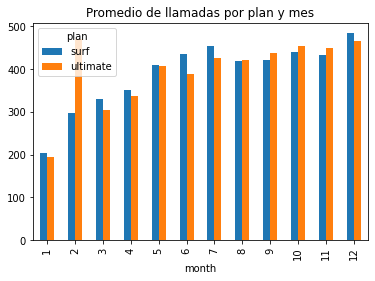

In [45]:
#grafico de barras comparando el promedio de llamadas por plan
grafica.plot(kind='bar', title='Promedio de llamadas por plan y mes') 
plt.show()

En el gráfico de barras, se observa que en 7 meses los usuarios de Surf superan en promedio a los de Ultimate. En el mes de febrero los usuarios de Ultimate superan en promedio a los de Surf.

In [46]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
minutes_month_users=users_total_information.pivot(index=['user_id','month'], columns='plan', values='minutes_calls')
minutes_month_users.sample(5)

,plan,surf,ultimate
user_id,month,,
1395,12,NaN,263.0
1167,6,646.0,NaN
1322,8,28.0,NaN
1245,12,374.0,NaN
1228,12,164.0,NaN


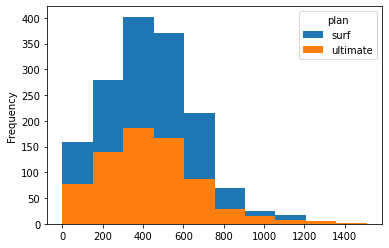

In [47]:
minutes_month_users.plot(kind='hist') #histograma de los planes, sesgada hacia la derecha
plt.show()

En el histograma se aprecia que los usuarios del plan *Surf* usan mas minutos que los del plan *Ultimate*; ademas el primero tamben cuenta con mayor cantidad de clientes.


Se calculara la media, varianza y un diagrama de caja de las llamadas para averiguar si los usuarios de los diferentes planes se comportan de manera diferente

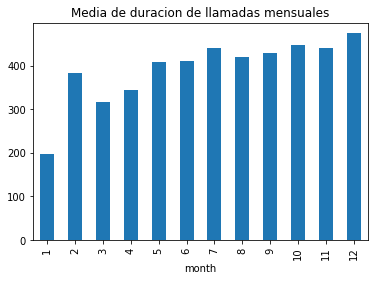

In [48]:
# Calcula la media y la varianza de la duración mensual de llamadas.
df_1.groupby('month')['minutes_calls'].mean().reset_index().plot(kind='bar', x='month',y='minutes_calls', 
                                                                                    legend=False
                                                                                   , title='Media de duracion de llamadas mensuales')
plt.show()

In [49]:
users_total_information.groupby(['month','plan'])['minutes_calls'].var().reset_index() #varianza por mes
#.plot(x='month',y='minutes_calls', legend=False)
#plt.show()

,month,plan,minutes_calls
0,1,surf,15842.000000
1,1,ultimate,16572.333333
2,2,surf,52226.500000
3,2,ultimate,54345.066667
4,3,surf,35809.363636
5,3,ultimate,61984.931818
6,4,surf,50866.743265
7,4,ultimate,34888.928571
8,5,surf,56938.779459
9,5,ultimate,43841.046798


In [50]:
#desviación estandar por mes
users_total_information.groupby(['month','plan'])['minutes_calls'].std().reset_index()

,month,plan,minutes_calls
0,1,surf,125.865007
1,1,ultimate,128.733575
2,2,surf,228.531179
3,2,ultimate,233.120284
4,3,surf,189.233622
5,3,ultimate,248.967732
6,4,surf,225.536567
7,4,ultimate,186.785783
8,5,surf,238.618481
9,5,ultimate,209.382537


En el cuadro anterior se observa las desviaciones por mes de los minutos utilizados por llamada con respecto a la media.

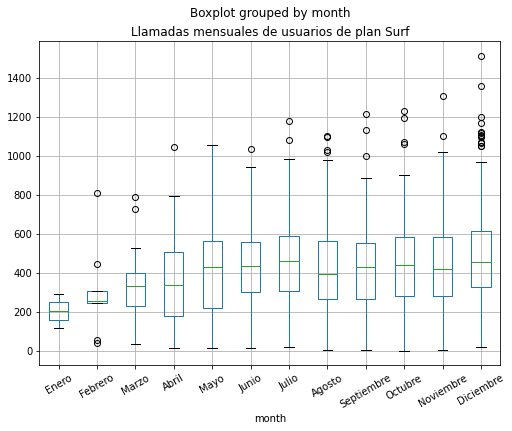

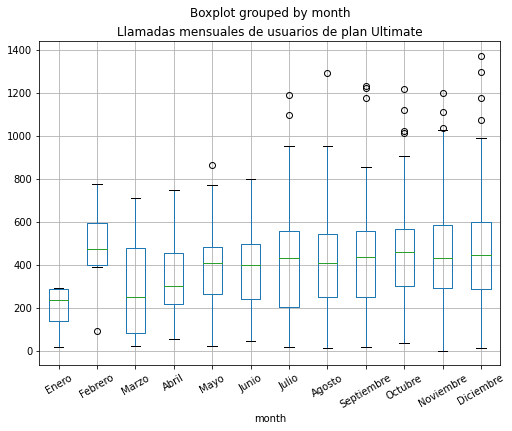

In [51]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

#filtramos y se realiza el digrama de caja por mes y plan Surf
users_total_information[users_total_information['plan']=='surf'].boxplot(column='minutes_calls', by='month', figsize=[8,6], rot=30)
plt.title('Llamadas mensuales de usuarios de plan Surf')

#cambiamos los numeros por los meses
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ['Enero', 'Febrero', 'Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre'],fontsize=10)

#filtramos y se realiza el digrama de caja por mes y plan Surf
users_total_information[users_total_information['plan']=='ultimate'].boxplot(column='minutes_calls', by='month', figsize=[8,6], rot=30)
plt.title('Llamadas mensuales de usuarios de plan Ultimate')

#cambiamos los numeros por los meses
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ['Enero', 'Febrero', 'Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre'],fontsize=10)
plt.show()


Para las llamadas, los usuarios de Surf tienen mayores valores atipicos que los de Ultimate, esto puede deberse a que no les es sufuciente su plan adquirido y terminan con minutos excedidos. Tambien se observa que para usuarios de ambos tipo de planes, los minutos van aumentando a cuanto se acerca fin de año, celebraciones como: acción de gracias, navidad o Halloween podrian ser los principales motivos.

### Mensajes

In [52]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
df_messages=users_total_information.groupby(['month','plan'])['number_messages'].sum().reset_index()
df_messages

,month,plan,number_messages
0,1,surf,21.0
1,1,ultimate,62.0
2,2,surf,108.0
3,2,ultimate,151.0
4,3,surf,351.0
5,3,ultimate,243.0
6,4,surf,870.0
7,4,ultimate,463.0
8,5,surf,1849.0
9,5,ultimate,931.0


In [53]:
grafica2=df_messages.pivot(index='month',columns='plan',values='number_messages') #para crear DF
grafica2

plan,surf,ultimate
month,,
1,21.0,62.0
2,108.0,151.0
3,351.0,243.0
4,870.0,463.0
5,1849.0,931.0
6,2454.0,1379.0
7,3271.0,1937.0
8,4662.0,2732.0
9,5968.0,3259.0


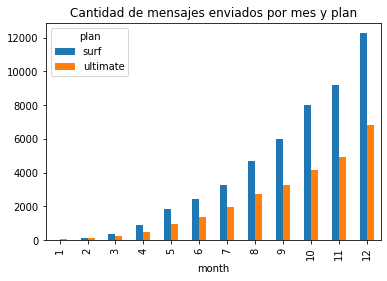

In [54]:
grafica2.plot(kind='bar', title='Cantidad de mensajes enviados por mes y plan') #sesgada hacia la derecha
plt.show()

Se observa que los usuarios de *Surf* enviaron mayores mensajes que los del plan *Ultimate*.

In [55]:
# Compara el número de mensajes mensuales que necesitan los usuarios de cada plan. Traza un histograma.
messages_month_users=users_total_information.pivot(index=['user_id','month'], columns='plan', values='number_messages')
messages_month_users.head()

plan           surf  ultimate
user_id month                
1000    12      NaN      11.0
1001    8      30.0       NaN
        9      44.0       NaN
        10     53.0       NaN
        11     36.0       NaN

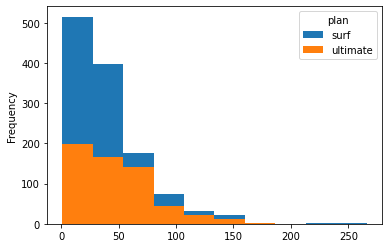

In [56]:
messages_month_users.plot(kind='hist')#sesgada hacia la derecha
plt.show()

Distribucion sesgada a la derecha, *Surf* usa de manera frecuente los mensajes que los del plan *Ultimate*.

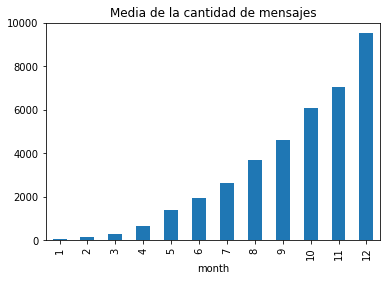

In [57]:
# Calcula la media y la varianza de mensajes.
#media
df_messages.groupby('month')['number_messages'].mean().reset_index().plot(kind='bar', x='month',y='number_messages',
                                                                                      legend=False, 
                                                                                      title='Media de la cantidad de mensajes')
plt.show()

In [58]:
#varianza
users_total_information.groupby(['month','plan'])['number_messages'].var().reset_index()

,month,plan,number_messages
0,1,surf,NaN
1,1,ultimate,310.333333
2,2,surf,512.800000
3,2,ultimate,465.366667
4,3,surf,352.062500
5,3,ultimate,613.904762
6,4,surf,534.028571
7,4,ultimate,512.862500
8,5,surf,867.945130
9,5,ultimate,1246.933333


In [59]:
#desviacion estandar
users_total_information.groupby(['month','plan'])['number_messages'].std().reset_index()

,month,plan,number_messages
0,1,surf,NaN
1,1,ultimate,17.616280
2,2,surf,22.645088
3,2,ultimate,21.572359
4,3,surf,18.763329
5,3,ultimate,24.777102
6,4,surf,23.109058
7,4,ultimate,22.646468
8,5,surf,29.460909
9,5,ultimate,35.311943


En el cuadro anterior se observa las desviaciones por mes del numero de mensajes con respecto a la media.

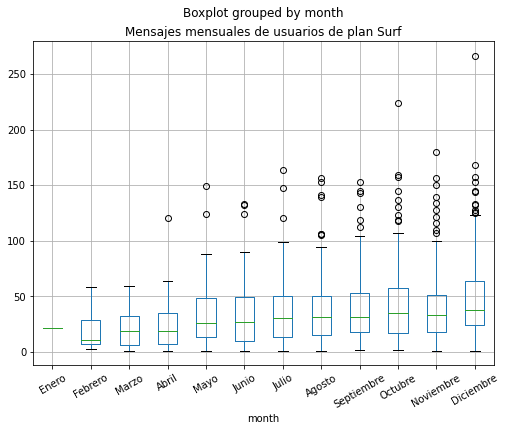

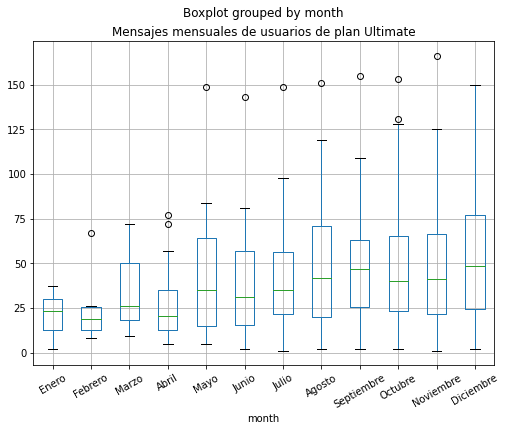

In [60]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de mensajes

#filtramos y se realiza el digrama de caja por mes y plan Surf
users_total_information[users_total_information['plan']=='surf'].boxplot(column='number_messages', by='month', figsize=[8,6], rot=30)
plt.title('Mensajes mensuales de usuarios de plan Surf')

plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ['Enero', 'Febrero', 'Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre'],fontsize=10)

#filtramos y se realiza el digrama de caja por mes y plan Ultimate
users_total_information[users_total_information['plan']=='ultimate'].boxplot(column='number_messages', by='month', figsize=[8,6], rot=30)
plt.title('Mensajes mensuales de usuarios de plan Ultimate')

plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ['Enero', 'Febrero', 'Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre'],fontsize=10)
plt.show()

Se observa en el diagrama de caja que los usuarios *Surf* tienen mayoresvalores atipicos, esto indica que envian mayores mensajes que los que se les brinda en su plan, como se menciono anteriormente esto tambien aumneta a fines de año, por festividades podria ser una razón. En los usuarios con planes *Ultimate* se encuentra menores valores atipicos sin embargo, a estos usuarios podrian en su mayoria ser suficiente su plan inclusive sobrar.

### Internet

In [61]:
# Compara la cantidad de tráfico de Internet consumido por mes por plan
df_internet=users_total_information.groupby(['month','plan'])['gb_used_month_int'].sum().reset_index()
df_internet

,month,plan,gb_used_month_int
0,1,surf,10.0
1,1,ultimate,29.0
2,2,surf,110.0
3,2,ultimate,121.0
4,3,surf,312.0
5,3,ultimate,221.0
6,4,surf,611.0
7,4,ultimate,343.0
8,5,surf,1087.0
9,5,ultimate,489.0


In [62]:
#se construye un DF
grafica3=df_internet.pivot(index='month', columns='plan', values='gb_used_month_int')
grafica3

plan,surf,ultimate
month,,
1,10.0,29.0
2,110.0,121.0
3,312.0,221.0
4,611.0,343.0
5,1087.0,489.0
6,1502.0,725.0
7,2042.0,973.0
8,2735.0,1267.0
9,3238.0,1463.0


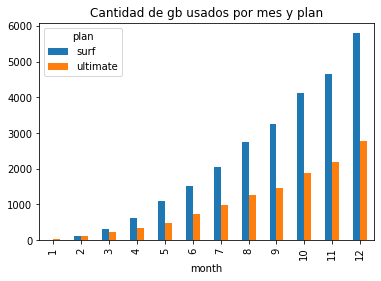

In [63]:
#grafico de barras para gb usados por plan
grafica3.plot(kind='bar', title='Cantidad de gb usados por mes y plan')
plt.show()

Se observa un mayor uso de internet para el plan *Surf*.

In [64]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
internet_month_users=users_total_information.pivot(index=['user_id', 'month'], columns='plan' , values='gb_used_month_int')
internet_month_users.head()

plan           surf  ultimate
user_id month                
1000    12      NaN       2.0
1001    8       7.0       NaN
        9      14.0       NaN
        10     22.0       NaN
        11     19.0       NaN

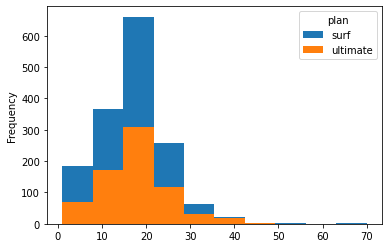

In [65]:
internet_month_users.plot(kind='hist')#histograma
plt.show()

Se observa una mayor frecuencia al cuanto al uso de internet de parte de los usuarios del plan *Surf* con respecto a los de *Ultimate*.

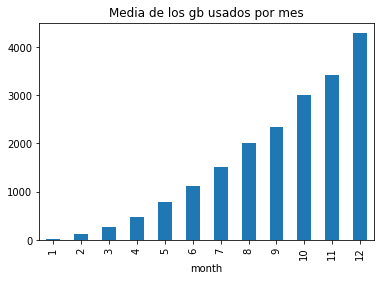

In [66]:
# Calcula la media y la varianza del uso de internet.
#media
df_internet.groupby('month')['gb_used_month_int'].mean().reset_index().plot(kind='bar', x='month',y='gb_used_month_int', 
                                                                            legend=False, title='Media de los gb usados por mes')
plt.show()

La media de uso aumenta en cuanto se acerca fin de año.

In [67]:
users_total_information.groupby(['month','plan'])['gb_used_month_int'].var().reset_index()

,month,plan,gb_used_month_int
0,1,surf,18.000000
1,1,ultimate,14.916667
2,2,surf,41.444444
3,2,ultimate,37.904762
4,3,surf,63.984190
5,3,ultimate,138.628788
6,4,surf,54.212585
7,4,ultimate,85.833333
8,5,surf,56.267193
9,5,ultimate,54.194581


In [68]:
users_total_information.groupby(['month','plan'])['gb_used_month_int'].std().reset_index()

,month,plan,gb_used_month_int
0,1,surf,4.242641
1,1,ultimate,3.862210
2,2,surf,6.437736
3,2,ultimate,6.156684
4,3,surf,7.999012
5,3,ultimate,11.774073
6,4,surf,7.362920
7,4,ultimate,9.264628
8,5,surf,7.501146
9,5,ultimate,7.361697


La desviacion entre los planes no se encuentran alejadas entre sí.

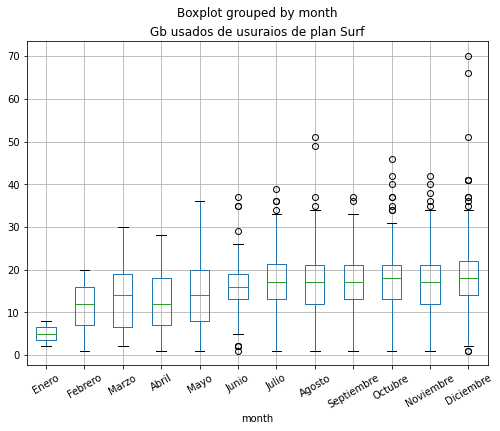

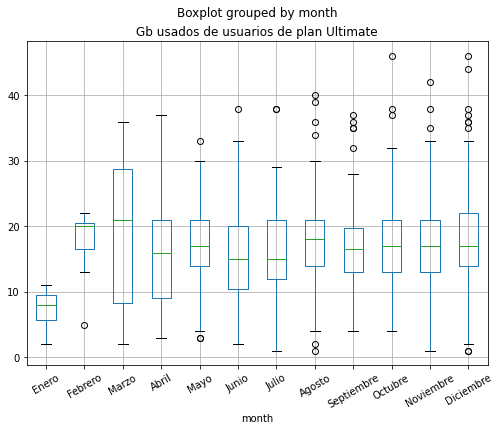

In [69]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de mensajes
#filtramos y se realiza el digrama de caja por mes y plan Surf
users_total_information[users_total_information['plan']=='surf'].boxplot(column='gb_used_month_int', by='month', figsize=[8,6], rot=30)
plt.title('Gb usados de usuraios de plan Surf')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ['Enero', 'Febrero', 'Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre'],fontsize=10)

#filtramos y se realiza el digrama de caja por mes y plan Ultimate
users_total_information[users_total_information['plan']=='ultimate'].boxplot(column='gb_used_month_int', by='month', figsize=[8,6], rot=30)
plt.title('Gb usados de usuarios de plan Ultimate')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ['Enero', 'Febrero', 'Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre'],fontsize=10)
plt.show()

Para ambos planes se observa que existen varios datos atipicos, mientras se acerca fin de año.

## Ingreso

Se describira a continuacion los ingresos que genera cada plan.

In [70]:
#En promedio cuanto genera cada plan 
bar_usd_monthly_pay=users_total_information.groupby('plan')['usd_monthly_pay'].mean() #pago regular

#pago con extras por excederse del limite del plan
bar_total_usd_user=users_total_information.groupby('plan')['total_usd_user'].mean() 

In [71]:
concatenate=pd.concat([bar_usd_monthly_pay,bar_total_usd_user],axis='columns') #concatenamos lo cuadros anteriores
concatenate

,usd_monthly_pay,total_usd_user
plan,,
surf,20,60.706408
ultimate,70,72.313889


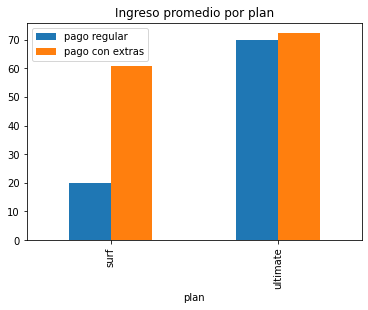

In [72]:
concatenate.rename(columns={'usd_monthly_pay':'pago regular', 'total_usd_user':'pago con extras'}).plot(kind='bar', title='Ingreso promedio por plan') #grafico de barras
plt.show()

El plan *Ultimate* en promedio genera mayores ingresos en comparacion con el *Surf*, incluyendo cuando se le cobra con la tarifa adicional al ecederse de sus planes.

In [73]:
#Se analizará ahora con la suma de los ingresos
bar_usd_monthly_pay=users_total_information.groupby('plan')['usd_monthly_pay'].sum() #pago regular
bar_total_usd_user=users_total_information.groupby('plan')['total_usd_user'].sum()   #pago con extra

In [74]:
concatenate=pd.concat([bar_usd_monthly_pay,bar_total_usd_user],axis='columns') #concatenamos
concatenate

,usd_monthly_pay,total_usd_user
plan,,
surf,31460,95491.18
ultimate,50400,52066.00


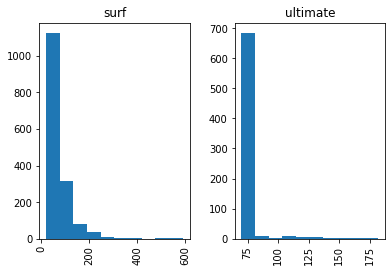

In [75]:
users_total_information.hist(column='total_usd_user',by='plan')
plt.show()

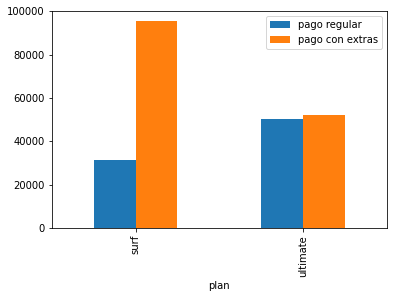

In [76]:
concatenate.rename(columns={'usd_monthly_pay':'pago regular', 'total_usd_user':'pago con extras'}).plot(kind='bar') #grafico de barras
plt.show()

En el pago regular de los planes, *Ultimate* genera mayores ingresos que *Surf*, por otra parte este último genera mas con los pagos adicionales que *Ultimate*. Los usuarios *Surf* parecen no bastarles con su plan y recurren a los mb, mensajes y llamadas extras.

In [77]:
users_total_information.groupby(['month','plan'])['total_usd_user'].var().reset_index()

,month,plan,total_usd_user
0,1,surf,0.000000
1,1,ultimate,0.000000
2,2,surf,428.276100
3,2,ultimate,0.000000
4,3,surf,1512.023512
5,3,ultimate,145.515152
6,4,surf,1198.958402
7,4,ultimate,120.400000
8,5,surf,1967.540055
9,5,ultimate,15.206897


Las varianzas se apartan de la media mas usualmente en el plan *Surf*.

## Prueba las hipótesis estadísticas


A continuación se propondra una hipotesis que se rechazará o no, esta en referencia a si los ingresos de los usuarios de *Ultimate* y *Surf* son diferentes

**Ho= Los ingresos promedio procedentes de los usuarios de los planes de Ultimate y Surf son iguales**

**Ha= Los ingresos promedio procedentes de los usuarios de los planes de Ultimate y Surf NO son iguales**

In [78]:
#filtramos para los usuarios del plan Surf y la cantidad total de ingresos
users_surf=users_total_information[users_total_information['plan']=='surf']['total_usd_user']

#filtramos para los usuarios del plan Ultimate
users_utimate=users_total_information[users_total_information['plan']=='ultimate']['total_usd_user']

In [79]:
# Prueba las hipótesis
#Hipotesis sobre la igualdad de las medias de dos poblaciones
#una proveniente de Surf y la otra de Ultimate
alpha=0.05 #nivel de significancia

results=st.ttest_ind(users_surf,users_utimate) #ttest
valorp=results.pvalue
print(valorp) #valor de t obtenido

#condicional para comparar el p con el alpha
if valorp<alpha:
    print('Se rechaza la hipotesis nula')
else:
    print('No se rechaza la hipotesis nula')

2.862674510698644e-08
Se rechaza la hipotesis nula


Al caer en la zona crítica se rechaza la hipotesis nula, es decir que es muy poco probable que los ingresos de ambos planes sean iguales, al menos con los datos que tenemos.


Se propondra la hipotesis de que el ingreso promedio de los usuarios que pertenecen al area de NY-NY frente a los otras ciudades, son diferentes.

**Ho= Los ingresos promedio procedentes de los usuarios del área de NY-NJ son iguales**

**Ha= Los ingresos promedio procedentes de los usuarios del área de NY-NJ NO son iguales**

In [80]:
#usamos unique para escoger la cuidad a filtrar
users_total_information['city'].unique()

array(['Atlanta-Sandy Springs-Roswell, GA MSA',
       'Seattle-Tacoma-Bellevue, WA MSA',
       'Las Vegas-Henderson-Paradise, NV MSA', 'Tulsa, OK MSA',
       'Dallas-Fort Worth-Arlington, TX MSA',
       'San Francisco-Oakland-Berkeley, CA MSA',
       'Grand Rapids-Kentwood, MI MSA',
       'Orlando-Kissimmee-Sanford, FL MSA',
       'San Jose-Sunnyvale-Santa Clara, CA MSA',
       'Cleveland-Elyria, OH MSA',
       'Chicago-Naperville-Elgin, IL-IN-WI MSA', 'Knoxville, TN MSA',
       'New York-Newark-Jersey City, NY-NJ-PA MSA', 'Pittsburgh, PA MSA',
       'Fresno, CA MSA',
       'Washington-Arlington-Alexandria, DC-VA-MD-WV MSA',
       'Indianapolis-Carmel-Anderson, IN MSA', 'Jacksonville, FL MSA',
       'Los Angeles-Long Beach-Anaheim, CA MSA',
       'Omaha-Council Bluffs, NE-IA MSA',
       'Houston-The Woodlands-Sugar Land, TX MSA',
       'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA',
       'Tampa-St. Petersburg-Clearwater, FL MSA',
       'Birmingham-Hoover, AL MSA'

In [81]:
#filtramos para los usuarios con la cantidad de ingresos que pertenecen a NY-NJ
ny_nj_city1=users_total_information[users_total_information['city']=='New York-Newark-Jersey City, NY-NJ-PA MSA']['total_usd_user']

#filtramos para los usuarios con la cantidad de ingresos que no pertenecen a NY-NJ
other_cities1=users_total_information[users_total_information['city']!='New York-Newark-Jersey City, NY-NJ-PA MSA']['total_usd_user']

In [82]:
# Prueba las hipótesis
alpha=0.05 #nivel de significancia
results=st.ttest_ind(ny_nj_city1,other_cities1) #ttest
valorp=results.pvalue
print(valorp)

#condicional para comparar el p con el alpha
if valorp<alpha:
    print('Se rechaza la hipotesis nula')
else:
    print('No se rechaza la hipotesis nula')

0.043557431621342436
Se rechaza la hipotesis nula


Al caer en la zona crítica se rechaza la hipotesis nula, es decir que es muy poco probable que los ingresos que pertenecen a usuarios de la ciudad de NY-NJ sea igual al resto de las ciudades, al menos con los datos presentes.

## Conclusión general

1. Los usuarios analizados pertenecen a dos planes: *Surf* y *Ultimate*, ambos contienes cantidad de mensajes, minutos y gb por utilizar, también se cuenta con una tarifa en caso el usuario sobrepaso los limites de su plan.

2. Se convirtio los *mb* a *gb* por politicas de la empresa a su superior inmediato, lo cual redondeado ayuda en los calculos para los ingresos extras, que se tienen al excederse algunos usuarios de su plan.

3. De manera analoga se convitio los minutos de las llamadas a su superior inmediato para encontrar los calculos de los ingresos extras, que se tienen al excederse algunos usuarios de su plan.

4. Entre los usuarios de ambos planes se presenta que aumenta la cantidad de *mb, llamadas* y *minutos* utilizados mientras se acerca mas a fin de año, esto podría deberse a las festividades.

5. Los usuarios de ambos planes presentan desviaciones no tan alejadas entre sí en cuanto a *mensajes, llamadas* y *mb*, sin embargo se observa una varianza en cuanto a los ingresos que es mayor en el plan *Surf*, esto podría deberse a que parte de los usuarios no les es suficiente lo brindado, con lo que se recurre a los pagos extras.

6. Los usuarios de *Ultimate* generan mayores ingresos que los de *Surf* sin considerarse los extras; sin embargo, el plan *Surf* como se aprecia en el grafico de la sección Ingresos genera mayores ingresos al sumarse los pagos adicionales que se cargan al usuario por excederse de su plan. Se recomienda que se analice por que medio se desea generar mayor ingreso ya sea por pago regular o si se eligen por los cargos adicionales.

7. Se rechazó la la hipotesis nula de que los ingresos de ambos planes sean iguales, al menos con los datos que tenemos es muy poco probable que estos lo sean.

8. Se rechazó la hipotesis nula de que los ingresos que pertenecen a usuarios de la ciudad de NY-NJ sea igual al resto de las ciudades, al menos con los datos que se tiene es muy poco probable que estos lo sean.